# DETR Finetuned on Bone Fracture Dataset
code ref:
1. https://github.com/NielsRogge/Transformers-Tutorials/blob/master/DETR/Fine_tuning_DetrForSegmentation_on_custom_dataset_end_to_end_approach.ipynb
2. https://www.kaggle.com/code/nouamane/fine-tuning-detr-for-license-plates-detection/notebook
3. https://github.com/woctezuma/finetune-detr?tab=readme-ov-file

In [1]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

Using device: cuda



In [2]:
!pip install -q git+https://github.com/huggingface/transformers.git timm
!pip install pytorch-lightning
!pip install transformers

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 802.3/802.3 kB 4.6 MB/s eta 0:00:00
   ---------------------------------------- 868.8/868.8 kB 4.6 MB/s eta 0:00:00
   ---------------------------------------- 371.6/371.6 kB 5.8 MB/s eta 0:00:00
   ---------------------------------------- 50.7/50.7 kB ? eta 0:00:00
   ---------------------------------------- 76.9/76.9 kB 4.4 MB/s eta 0:00:00


Defaulting to user installation because normal site-packages is not writeable


## Prepare Dataset

In [3]:
!pip3 install roboflow

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 75.5/75.5 kB 2.1 MB/s eta 0:00:00
   ---------------------------------------- 158.3/158.3 kB 4.8 MB/s eta 0:00:00
   ---------------------------------------- 58.8/58.8 kB ? eta 0:00:00
   ---------------------------------------- 38.0/38.0 MB 8.1 MB/s eta 0:00:00
   ---------------------------------------- 54.5/54.5 kB 2.8 MB/s eta 0:00:00


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [4]:
from roboflow import Roboflow

rf = Roboflow(api_key="gjzgBjQF43hqhywOXEKm")
project = rf.workspace("veda").project("bone-fracture-detection-daoon")
version = project.version(4)
dataset = version.download("coco")

C:\Users\Amethyst-L\AppData\Roaming\Python\Python39\site-packages\matplotlib\projections\__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to bone-fracture-detection-4 in coco:: 100%|██████████| 4156/4156 [00:03<00:00, 1278.45it/s]


### Pre-processing
Feature extractor (DetrFeatureExtractor) is to resize and normalize the images, and to turn the annotations (COCO format) into the DETR format. It will also resize the annotations accordingly.

In [5]:
import torchvision
import os

class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, feature_extractor):
        ann_file = os.path.join(img_folder, "_annotations.coco.json")
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self.feature_extractor = feature_extractor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        img, target = super(CocoDetection, self).__getitem__(idx)
        
        # preprocess image and target (converting target to DETR format, resizing + normalization of both image and target)
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        encoding = self.feature_extractor(images=img, annotations=target, return_tensors="pt")
        # remove batch dimension
        pixel_values = encoding["pixel_values"].squeeze()
        target = encoding["labels"][0]    # label

        return pixel_values, target

In [6]:
from transformers import DetrFeatureExtractor

img_folder = "bone-fracture-detection-4"

feature_extractor = DetrFeatureExtractor.from_pretrained("facebook/detr-resnet-50")

train_dataset = CocoDetection(img_folder=f'{img_folder}/train', feature_extractor=feature_extractor)
val_dataset = CocoDetection(img_folder=f'{img_folder}/valid', feature_extractor=feature_extractor)
test_dataset = CocoDetection(img_folder=f'{img_folder}/test', feature_extractor=feature_extractor)

A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4


preprocessor_config.json:   0%|          | 0.00/290 [00:00<?, ?B/s]

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


`huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Amethyst-L\.cache\huggingface\hub\models--facebook--detr-resnet-50. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
The class DetrFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DetrImageProcessor instead.


In [7]:
print("Training dataset size: ", len(train_dataset))
print("Validation dataset size: ", len(val_dataset))
print("Testing dataset size: ", len(test_dataset))

Training dataset size:  3631
Validation dataset size:  348
Testing dataset size:  169


### Visualization

Image n°3210


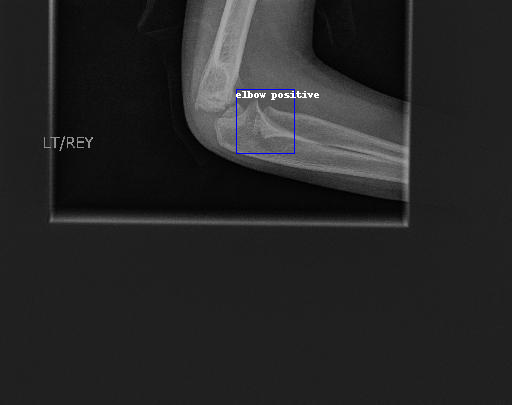

In [8]:
import numpy as np
import os
from PIL import Image, ImageDraw

# based on https://github.com/woctezuma/finetune-detr/blob/master/finetune_detr.ipynb
image_ids = train_dataset.coco.getImgIds()
# pick a random image
image_id = image_ids[np.random.randint(0, len(image_ids))]
print('Image n°{}'.format(image_id))
image = train_dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join(f'{img_folder}/train', image['file_name']))

annotations = train_dataset.coco.imgToAnns[image_id]
draw = ImageDraw.Draw(image, "RGBA")

cats = train_dataset.coco.cats
id2label = {k: v['name'] for k,v in cats.items()}

for annotation in annotations:
    box = annotation['bbox']
    class_idx = annotation['category_id']
    x,y,w,h = tuple(box)
    draw.rectangle((x,y,x+w,y+h), outline='blue', width=1)
    draw.text((x, y), id2label[class_idx], fill='white')

image

### Dataloader Preparation
As DETR resizes images to have a min size of 800 and a max size of 1333, images can have different sizes. We pad images (pixel_values) to the largest image in a batch, and create a corresponding pixel_mask to indicate which pixels are real (1)/which are padding (0).

In [9]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    pixel_values = [item[0] for item in batch]
    encoding = feature_extractor.pad(pixel_values, return_tensors="pt")
    labels = [item[1] for item in batch]
    
    batch = {}
    batch['pixel_values'] = encoding['pixel_values']
    batch['pixel_mask'] = encoding['pixel_mask']
    batch['labels'] = labels
    
    return batch

train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=4, shuffle=True)
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=4)
test_dataloader = DataLoader(test_dataset, collate_fn=collate_fn, batch_size=4)

In [10]:
pixel_values, target = train_dataset[2]
print(pixel_values.shape)
print(target)

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


torch.Size([3, 800, 800])
{'size': tensor([800, 800]), 'image_id': tensor([2]), 'class_labels': tensor([2]), 'boxes': tensor([[0.6662, 0.4122, 0.0472, 0.0587]]), 'area': tensor([1774.3750]), 'iscrowd': tensor([0]), 'orig_size': tensor([512, 512])}


## Finetuning

In [11]:
id2label

{0: 'bones',
 1: 'elbow positive',
 2: 'fingers positive',
 3: 'forearm fracture',
 4: 'humerus',
 5: 'humerus fracture',
 6: 'shoulder fracture',
 7: 'wrist positive'}

In [12]:
import pytorch_lightning as pl
from transformers import DetrConfig, DetrForObjectDetection
import torch

class Detr(pl.LightningModule):
    def __init__(self, lr, lr_backbone, weight_decay):
            super().__init__()
            # replace COCO classification head with custom head
            self.model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50", 
                                                             num_labels=len(id2label),
                                                             ignore_mismatched_sizes=True)
            
            
            # see https://github.com/PyTorchLightning/pytorch-lightning/pull/1896
            self.lr = lr
            self.lr_backbone = lr_backbone
            self.weight_decay = weight_decay
    
    def forward(self, pixel_values, pixel_mask):
        outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)
        return outputs
     
    def common_step(self, batch, batch_idx):
        pixel_values = batch["pixel_values"]
        pixel_mask = batch["pixel_mask"]
        labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

        outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

        loss = outputs.loss
        loss_dict = outputs.loss_dict

        return loss, loss_dict
 
    def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        # logs metrics for each training_step,
        # and the average across the epoch
        self.log("training_loss", loss)
        for k,v in loss_dict.items():
            self.log("train_" + k, v.item())

        return loss

    def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        self.log("validation_loss", loss)
        for k,v in loss_dict.items():
            self.log("validation_" + k, v.item())

        return loss

    def configure_optimizers(self):
        param_dicts = [
              {"params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
              {
                  "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                  "lr": self.lr_backbone,
              },
        ]
        optimizer = torch.optim.AdamW(param_dicts, lr=self.lr,
                                  weight_decay=self.weight_decay)
        
        return optimizer

    def train_dataloader(self):
        return train_dataloader

    def val_dataloader(self):
        return val_dataloader

In [14]:
model = Detr(lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4)

model.safetensors:  10%|#         | 10.5M/102M [00:00<?, ?B/s]

Error while downloading from https://cdn-lfs.huggingface.co/repos/b0/7c/b07c8514311ce8b4837f2b7bd470e8ff9e31efce9ecc5a1d7884e4ebb95269bd/773525d5821de224f8f30c33377b7a795d7863e08522698200d3217d3f2a41bb?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27model.safetensors%3B+filename%3D%22model.safetensors%22%3B&Expires=1717304026&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcxNzMwNDAyNn19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5odWdnaW5nZmFjZS5jby9yZXBvcy9iMC83Yy9iMDdjODUxNDMxMWNlOGI0ODM3ZjJiN2JkNDcwZThmZjllMzFlZmNlOWVjYzVhMWQ3ODg0ZTRlYmI5NTI2OWJkLzc3MzUyNWQ1ODIxZGUyMjRmOGYzMGMzMzM3N2I3YTc5NWQ3ODYzZTA4NTIyNjk4MjAwZDMyMTdkM2YyYTQxYmI%7EcmVzcG9uc2UtY29udGVudC1kaXNwb3NpdGlvbj0qIn1dfQ__&Signature=i9BYIZW0LpE8nFjfSBCYA77SmNE9bbttoL4pr-6ag4kzMuyanBOMQUEE-hFmjo6qXN8fzxDW5An1rg--M2sPHlMP3qbVEwEV1cFhzHU7J8U-zMmaZ2AGS7K2%7EtNUyLL7VUrV6vOjpalYnwFsOOJdQpEWA%7Egcn3VJAC-On4wEjaKL5bvIopoXb%7E4MV3jYMj3jtLla0kYe427%7EU56eo1EGZoY%7Ep1GyBftr%7E0a5qy

model.safetensors:  20%|##        | 21.0M/102M [00:00<?, ?B/s]

`huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Amethyst-L\.cache\huggingface\hub\models--timm--resnet50.a1_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.mod

In [15]:
# pick the first training batch
batch = next(iter(train_dataloader))
# forward through the model
outputs = model(pixel_values=batch['pixel_values'], pixel_mask=batch['pixel_mask'])

In [16]:
print("Shape of pixel_values:", pixel_values.shape)
print("Shape of logits:", outputs.logits.shape)    # Shape: (batch_size, num_queries, number of classes + 1)

Shape of pixel_values: torch.Size([3, 800, 800])
Shape of logits: torch.Size([4, 100, 9])


In [17]:
from pytorch_lightning import Trainer
from tqdm.notebook import tqdm

trainer = Trainer(devices=1, accelerator="auto", gradient_clip_val=0.1, max_epochs=10)
trainer.fit(model, train_dataloader, val_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3050 4GB Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Missing logger folder: d:\Python-Code\ECE228\project\lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                   | Params
-------------------------------------------------
0 | model | DetrForObjectDetection | 41.5 M
-------------------------------------------------
41.3 M    Trainable params
222 K     Non-trainable params
41.5 M    Total params
166.014   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\Amethyst-L\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
C:\Users\Amethyst-L\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\utilities\data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 4. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
C:\Users\Amethyst-L\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\connectors\data_connector.

Training: |          | 0/? [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 126.00 MiB. GPU 